In [30]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import csv
import pickle
import random
import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
import tensorflow.keras as keras

from scipy import ndimage

In [31]:
# DCM Series Number extraction for CT_SCANS images from csv file

series = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        if row[-2][-3:] == 'cor':
            series.append([row[0], row[2], row[3], row[-9], row[-2],row[-1]])


series = sorted(series, key=lambda x: (x[0],x[1]))

print(np.asarray(series).shape)
print(series)

(339, 6)
[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '139 166 12', 't2_tse_cor', '5'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '131 177 6', 't2_tse_cor', '5'], ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '128 171 12', 't2_tse_cor', '5'], ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', '170 186 12', 't2_tse_cor', '5'], ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', '199 154 14', 't2_tse_cor', '4'], ['ProstateX-0003', '2', '-21.2871 19.3995 19.7429', '126 134 7', 't2_tse_cor', '4'], ['ProstateX-0004', '1', '-7.69665 3.64226 23.1659', '173 172 7', 't2_tse_cor', '4'], ['ProstateX-0005', '0', '-14.5174331665039 49.4428329467773 20.7815246582031', '168 151 12', 't2_tse_cor', '5'], ['ProstateX-0005', '1', '-22.0892639160156 25.4668045043945 22.8791542053223', '156 151 4', 't2_tse_cor', '5'], ['ProstateX-0005', '1', '-38.6276 42.2781 21.4084', '128 151 10', 't2_tse_cor', '5'], ['ProstateX-0006', '1', '8.20024 28.2665 -10.4784', '1

In [32]:
# True or false extraction for ADC images from csv file

clinsig = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Findings-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        clinsig.append([row[0],row[1], row[2], row[-1]])
    clinsig.remove(clinsig[0])

clinsig2 = clinsig
#for n in range(len(clinsig)):
    #print(n, clinsig[n])
    
cp = []
cl = clinsig.copy()
j=0
n=0
seen = []

while j != len(series):
    if clinsig[n][0] == series[j][0] and clinsig[n][1] == series[j][1] and clinsig[n][2] == series[j][2]:
        if clinsig[n] not in seen:
            cp.append([clinsig[n], series[j]])
            seen.append(clinsig[n])
        j+=1
    n+=1
    if n == len(clinsig):
        n=0

print(clinsig)
print(len(clinsig))

[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'], ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', 'TRUE'], ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', 'FALSE'], ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', 'FALSE'], ['ProstateX-0003', '2', '-21.2871 19.3995 19.7429', 'FALSE'], ['ProstateX-0004', '1', '-7.69665 3.64226 23.1659', 'FALSE'], ['ProstateX-0005', '0', '-14.5174331665039 49.4428329467773 20.7815246582031', 'TRUE'], ['ProstateX-0005', '1', '-38.6276 42.2781 21.4084', 'TRUE'], ['ProstateX-0005', '1', '-22.0892639160156 25.4668045043945 22.8791542053223', 'FALSE'], ['ProstateX-0006', '1', '8.20024 28.2665 -10.4784', 'FALSE'], ['ProstateX-0006', '2', '-9.85971 37.2739 0.561445', 'FALSE'], ['ProstateX-0007', '1', '-5.4258 20.1075 -57.34', 'FALSE'], ['ProstateX-0008', '1', '25.2302 38.6613 -26.864', 'FALSE'], ['ProstateX-0009', '1', '19.565 32.8037 -37.4421', 'FALSE

In [33]:
series = []
clinsig = []
for i in range(0,len(cp)):
    clinsig.append(cp[i][0])
    series.append(cp[i][1])
    

    
print(len(series), len(clinsig), series[0])

330 330 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '139 166 12', 't2_tse_cor', '5']


In [34]:
# file filter from preceding listing



import os
def directory_find(atom, root, series):
    for path, dirs, files in os.walk(root):
        if atom in files:
            seriesPath = os.path.join(path, atom).split('/')
            tempPath = os.path.join(path,atom)
            if seriesPath[-2][0] == series[n][-1]  and seriesPath[-2][1] == ".":
                return tempPath[:-8]
            if seriesPath[-2][0:2] == series[n][-1] and seriesPath[-2][2] == ".":
                return tempPath[:-8]

            
paths = []
for n in range(len(series)):
    paths.append(directory_find('1-01.dcm','/Users/langletmaxime/Desktop/ProstateX/PROSTATEx/'+series[n][0], series))
print(len(paths))

330


In [35]:
#exctracting coeficients ijk

ijk = []
for n in range(len(series)):
    temp2 = []
    temp = series[n][3].split(' ')
    temp = np.asarray(temp)
    temp2.append([temp[0].astype(int), temp[1].astype(int), temp[2].astype(int)])
    ijk.append(temp2[0])

    
print(len(ijk))

330


In [36]:
# File storing into an array and sorted out

def file_storing(root):
    files_stored = []
    for path, dirs, files in os.walk(root):
        files = sorted(files, key = lambda x: x[:-4])
        for file in files:
            ds = dicom.dcmread(path+file)
            files_stored.append(ds)
    return files_stored

  
files_stored = []

for n in range(len(paths)):
    files_stored.append(file_storing(paths[n]))
    
print(len(files_stored), len(ijk))

330 330


In [37]:
# rectifying problem with k = 25 and k<0
# necessary if not prbm later
cp = []
for n in range(len(ijk)):
    if (ijk[n][2] < 0 or ijk[n][2] > len(files_stored[n])):
        print(n, ijk[n])
        cp.append(n)


i=0
for n in cp:
    ijk.remove(ijk[n-i])
    files_stored.remove(files_stored[n-i])
    series.remove(series[n-i])
    clinsig.remove(clinsig[n-i])
    i+=1

print(len(files_stored), len(ijk), len(series), len(clinsig))

35 [159, 161, 18]
42 [172, 122, 17]
208 [153, 171, 18]
210 [139, 156, 18]
270 [208, 164, 18]
325 325 325 325


In [38]:
# so we only have an array of picture and not dicom files then to gray scale 

for n in range(len(files_stored)):
    for i in range(len(files_stored[n])):
        files_stored[n][i] = files_stored[n][i].pixel_array
        files_stored[n][i] = files_stored[n][i].astype(float)
        files_stored[n][i] = (np.maximum(files_stored[n][i],0) / files_stored[n][i].max()) * 255.0
        files_stored[n][i] = np.uint8(files_stored[n][i])

(40, 40)


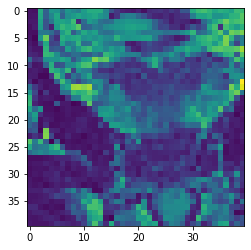

In [39]:
files_stored2 = []

for i in range(len(files_stored)):
    x, y = ijk[i][0], ijk[i][1]
    pic = files_stored[i][ijk[i][2]-1][ijk[i][1]-80:ijk[i][1]+80, ijk[i][0]-80:ijk[i][0]+80]
    pic = cv2.resize(pic,(40, 40))#80, 80
    #pic2 = files_stored[i][ijk[i][2]-1][ijk[i][1]-20:ijk[i][1]+20, ijk[i][0]-20:ijk[i][0]+20]
    files_stored2.append(pic)
    
#plt.imshow(files_stored2[0])
print(np.asarray(files_stored2[0]).shape)# dimensions ok with all the corrections. 
plt.figure()
plt.imshow(files_stored2[0])
plt.show()


In [40]:
#ATTENTION: CNN not really DNN see real difference

batch_size = 32
img_height = 40 # 80
img_width = 40 # 80

#for now we are not going to test the training on the test database

In [41]:
final = np.zeros((len(files_stored),img_height,img_width,1))

for n in range(len(files_stored2)):
    for i in range(len(files_stored2[0])):
        for j in range(len(files_stored2[0])):
            final[n][i][j][0] = files_stored2[n][i][j]
print(final.shape)

category = []
training_data = []
j=0
for i in range(len(clinsig)):
    if clinsig[i][3] == "TRUE":
        category.append(1)
    else:
        category.append(0)
        j +=1
print(len(category), j)#  we have a biais, keep in mind 

for k in range(len(category)):
    training_data.append([final[k], category[k]])
#print(test_data[0])

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, img_height, img_width, 1))
X = np.array(X).reshape(-1, img_height, img_width, 1)

y= np.asarray(y)

(325, 40, 40, 1)
325 249


In [42]:
#nmbre for splitting test patients from training patients
nbr = 225

In [43]:
X_test = X[nbr:]
y_test = y[nbr:]

In [44]:
def equalize(im):   
    hist = np.histogram(im, bins=np.arange(257))[0] 
    c_hist = np.zeros((256,))
    c=0
    for j in range(256):
        c += hist[j]
        c_hist[j] = c
    # Normalize to 0-255 range & convert to integer
    lut_eq = (255*c_hist/c_hist.max()).astype('int')
    im_eq = lut_eq[im]
    return im_eq

In [45]:
def data_augmentation(files_stored_ct, clinsig, ijk2, resize):
    # Data augmentation
    data_augmented_ct = []
    category_augmented_ct = []
    training_data_augmented_ct = []
    ones=0
    zeros=0

    if resize:
        shiftx = 7
        shifty = -7
    else:
        shiftx = 3
        shifty = -3

    for i in range(len(files_stored_ct[:nbr])):
        #x, y = ijk[i][0], ijk[i][1]
        if clinsig[i][3] == "TRUE":
            #biasing problem
            category_augmented_ct.append(1)#category_augmented.append([0,1])
            if resize:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-80:ijk2[i][1]+80, ijk2[i][0]-80:ijk2[i][0]+80]
                pic = cv2.resize(pic,(img_height, img_width))
            else:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20:ijk2[i][1]+20, ijk2[i][0]-20:ijk2[i][0]+20]
            data_augmented_ct.append(pic)
            ones +=1

            category_augmented_ct.append(1)
            if resize:
                pic2 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-80+shiftx:ijk[i][1]+80+shiftx, ijk2[i][0]-80+shifty:ijk2[i][0]+80+shifty]
                pic2 = cv2.resize(pic,(img_height, img_width))
            else:
                pic2 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20+shiftx:ijk2[i][1]+20+shiftx, ijk2[i][0]-20+shifty:ijk2[i][0]+20+shifty]
            data_augmented_ct.append(pic2)
            ones +=1

            category_augmented_ct.append(1)
            if resize:
                pic3 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-80-shiftx:ijk2[i][1]+80-shiftx, ijk2[i][0]-80-shifty:ijk2[i][0]+80-shifty]
                pic3 = cv2.resize(pic,(img_height, img_width))
            else:
                pic3 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20-shiftx:ijk2[i][1]+20-shiftx, ijk2[i][0]-20-shifty:ijk2[i][0]+20-shifty]
            data_augmented_ct.append(pic3)
            ones +=1

            category_augmented_ct.append(1)
            if resize:
                pic4 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-80+shiftx:ijk2[i][1]+80+shiftx, ijk2[i][0]-80-shifty:ijk2[i][0]+80-shifty]
                pic4 = cv2.resize(pic,(img_height, img_width))
            else:
                pic4 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20+shiftx:ijk2[i][1]+20+shiftx, ijk2[i][0]-20-shifty:ijk2[i][0]+20-shifty]
            data_augmented_ct.append(pic4)
            ones +=1

            #flip
            category_augmented_ct.append(1)
            pic51 = np.fliplr(pic)
            pic52 = np.fliplr(pic2)
            pic53 = np.fliplr(pic3)
            pic54 = np.fliplr(pic4)
            #pic55 = np.fliplr(pic5)
            data_augmented_ct.append(pic51)
            ones +=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(pic52)
            ones +=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(pic53)
            ones +=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(pic54)
            ones +=1
            #category_augmented_ct.append(1)
            #data_augmented_ct.append(pic55)
            #ones +=1

            #dimming brightness
            category_augmented_ct.append(1)
            pic6 = pic/1.25
            pic62 = pic2/1.25
            pic63 = pic3/1.25
            data_augmented_ct.append(pic6)
            ones +=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(pic62)
            ones +=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(pic63)
            ones +=1

            #Rotating
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic, 15, reshape=False))
            ones+=1

            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic2, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic2, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic2, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic2, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic2, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic2, 15, reshape=False))
            ones+=1

            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic3, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic3, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic3, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic3, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic3, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic3, 15, reshape=False))
            ones+=1
            
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic4, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic4, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic4, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic4, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic4, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(1)
            data_augmented_ct.append(ndimage.rotate(pic4, 15, reshape=False))
            ones+=1
            
            #Contrast enhancement
            category_augmented_ct.append(1)
            data_augmented_ct.append(equalize(pic))
            ones+=1

            category_augmented_ct.append(1)
            data_augmented_ct.append(equalize(pic2))
            ones+=1

            category_augmented_ct.append(1)
            data_augmented_ct.append(equalize(pic3))
            ones+=1
            
            
            category_augmented_ct.append(1)
            data_augmented_ct.append(equalize(pic4))
            ones+=1

        else:
            category_augmented_ct.append(0)
            if resize:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-80:ijk2[i][1]+80, ijk2[i][0]-80:ijk2[i][0]+80]
                pic = cv2.resize(pic,(40, 40))
            else:
                pic = files_stored[i][ijk2[i][2]-1][ijk2[i][1]-20:ijk2[i][1]+20, ijk2[i][0]-20:ijk2[i][0]+20]
            data_augmented_ct.append(pic)

            #flip
            category_augmented_ct.append(0)
            pic2 = np.fliplr(pic)
            data_augmented_ct.append(pic2)

            #dimming brightness
            category_augmented_ct.append(0)
            pic2 = pic/1.5
            data_augmented_ct.append(pic2)

            #zeros +=3
            zeros +=1

            #Rotating
            category_augmented_ct.append(0)
            data_augmented_ct.append(ndimage.rotate(pic, 10, reshape=False))
            zeros+=1
            category_augmented_ct.append(0)
            data_augmented_ct.append(ndimage.rotate(pic, -10, reshape=False))
            zeros+=1
            category_augmented_ct.append(0)
            data_augmented_ct.append(ndimage.rotate(pic, 5, reshape=False))
            zeros+=1
            category_augmented_ct.append(0)
            data_augmented_ct.append(ndimage.rotate(pic, -5, reshape=False))
            zeros+=1
            category_augmented_ct.append(0)
            data_augmented_ct.append(ndimage.rotate(pic, -15, reshape=False))
            zeros+=1
            category_augmented_ct.append(0)
            data_augmented_ct.append(ndimage.rotate(pic, 15, reshape=False))
            zeros+=1

            #Contrast enhancement
            category_augmented_ct.append(0)
            data_augmented_ct.append(equalize(pic))
            zeros+=1
    return category_augmented_ct, data_augmented_ct, ones, zeros

category, data, on, zer = data_augmentation(files_stored, clinsig, ijk, True)

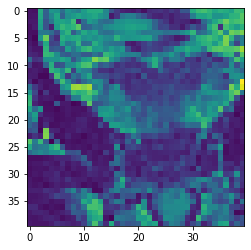

3671 3671 1911 1408


In [46]:
plt.figure()
plt.imshow(data[1])
plt.show()

category_augmented = category
data_augmented = data

print(len(data_augmented), len(category_augmented), on, zer)

In [47]:
print(np.asarray(data_augmented).shape)
final = np.zeros((np.asarray(data_augmented).shape[0],np.asarray(data_augmented).shape[1]
                  ,np.asarray(data_augmented).shape[2],1))

for n in range(len(data_augmented)):
    for i in range(len(data_augmented[0])):
        for j in range(len(data_augmented[0])):
            final[n][i][j][0] = data_augmented[n][i][j]
print(final.shape)

(3671, 40, 40)
(3671, 40, 40, 1)


In [48]:
training_data_augmented = []

for k in range(len(category_augmented)):
    training_data_augmented.append([final[k], category_augmented[k]])
    
random.shuffle(training_data_augmented)
print(len(training_data_augmented), k+1)
X = []
y = []

for features,label in training_data_augmented:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, img_height, img_width, 1))
X = np.array(X).reshape(-1, img_height, img_width, 1)

y = np.asarray(y)

print(X.shape)

3671 3671
(3671, 40, 40, 1)


In [49]:
pickle_out = open("X_COR.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y_COR.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [69]:
pickle_in = open("X_COR.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y_COR.pickle","rb")
y = pickle.load(pickle_in)

y = np.asarray(y)

print(X.shape[1:])

(40, 40, 1)


In [75]:
#X=X/255.0
#random.shuffle(X)
print(X.shape)

(3671, 40, 40, 1)


In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7)
#callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#regarder fully convolutionnal peut etre, plus de couche, enlever drop out dans un premier
#temps, 2 en sortie avec softmax

model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=X.shape[1:]))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(Conv2D(16, (3, 3), activation = 'relu'))
#model.add(Conv2D(2, (3, 3), activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Dropout(0.4))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dense(1, activation='sigmoid'))#activation='softmax'))
#2 en sortie avec softmax

opt = keras.optimizers.Adadelta()
model.compile(loss='binary_crossentropy',#loss='mse',
              optimizer='adam',
              #optimizer=opt,
              #metrics=[tf.keras.metrics.FalsePositives()])
              #metrics=['accuracy','mae'])
              metrics=['accuracy'])

model.fit(X, y, batch_size=32, epochs=100, validation_split=0.2, shuffle=True,callbacks=[callback])

Epoch 1/100
92/92 [==============================] - 3s 31ms/step - loss: 1.6340 - accuracy: 0.5539 - val_loss: 0.6287 - val_accuracy: 0.6313
Epoch 2/100
92/92 [==============================] - 3s 31ms/step - loss: 0.5974 - accuracy: 0.6931 - val_loss: 0.4350 - val_accuracy: 0.8136
Epoch 3/100
92/92 [==============================] - 3s 30ms/step - loss: 0.4325 - accuracy: 0.8248 - val_loss: 0.4641 - val_accuracy: 0.8531
Epoch 4/100
92/92 [==============================] - 3s 30ms/step - loss: 0.4208 - accuracy: 0.8619 - val_loss: 0.3523 - val_accuracy: 0.8776
Epoch 5/100
92/92 [==============================] - 3s 30ms/step - loss: 0.4266 - accuracy: 0.8859 - val_loss: 0.4407 - val_accuracy: 0.8993
Epoch 6/100
92/92 [==============================] - 3s 30ms/step - loss: 0.7754 - accuracy: 0.8947 - val_loss: 0.7191 - val_accuracy: 0.9129
Epoch 7/100
92/92 [==============================] - 3s 30ms/step - loss: 1.1433 - accuracy: 0.8912 - val_loss: 1.1252 - val_accuracy: 0.9088
Epoch 

In [77]:
'''
X = X/255.0
random.shuffle(X)


callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)#with 30 epochs
#callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=X.shape[1:]))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))#kernel_regularizer = regularizers.l1_l2(l1=0.0001, l2=0.0001)
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adadelta()
model.compile(loss='binary_crossentropy',#loss='mse',
              #optimizer='adam',
              optimizer=opt,
              #metrics=[tf.keras.metrics.FalsePositives()])
              #metrics=['accuracy','mae'])
              metrics=['accuracy'])

model.fit(X, y, batch_size=16, epochs=100, validation_split=0.25, shuffle=True,callbacks=[callback])
'''

'\nX = X/255.0\nrandom.shuffle(X)\n\n\ncallback = tf.keras.callbacks.EarlyStopping(monitor=\'val_accuracy\', patience=5)#with 30 epochs\n#callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)\n#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\n\nmodel = Sequential()\n\nmodel.add(Conv2D(32, kernel_size=(3,3), activation=\'relu\', input_shape=X.shape[1:]))\nmodel.add(Conv2D(32, (3, 3), activation = \'relu\'))\n#model.add(Dropout(0.5))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors\nmodel.add(Dropout(0.2))\n\nmodel.add(Dense(256, activation=\'relu\'))\nmodel.add(Dropout(0.2))\n\nmodel.add(Dense(128,activation=\'relu\'))#kernel_regularizer = regularizers.l1_l2(l1=0.0001, l2=0.0001)\nmodel.add(Dropout(0.2))\n\nmodel.add(Dense(1, activation=\'sigmoid\'))\n\nopt = keras.optimizers.Adadelta()\nmodel.compile(loss=\'binary_crossentropy\',#loss=\'

In [79]:
#model.evaluate(X[3500:],y[3500:])
model.evaluate(X_test,y_test)
predict = model.predict(X_test)

for i in range(len(predict)):
    print(predict[i], y_test[i])

4/4 [==============================] - 0s 8ms/step - loss: 679759.6875 - accuracy: 0.6600
[1.] 0
[0.] 1
[0.] 0
[0.] 0
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 0
[1.] 0
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 1
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 1
[0.] 0
[1.] 0
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 1
[1.] 1
[0.] 0
[0.] 1
[0.] 0
[1.] 1
[0.] 0
[1.] 1
[1.] 0
[0.] 1
[1.] 0
[1.] 1
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 0
[0.] 1
[0.] 0
[0.] 0
[0.] 1
[0.] 0
[1.] 0
[0.] 0
[0.] 0
[1.] 1
[0.] 1
[0.] 1
[0.] 1
[0.] 1
[0.] 1
[0.] 1
[0.] 1
[0.] 1
[1.] 1
[0.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[0.] 1
[0.] 1


In [54]:
#model.save('saved_model/model_combined') #95%

In [55]:
#model = Sequential()
#model = tf.keras.models.load_model('saved_model/my_model')
#model.summary()

In [74]:
test = []
test.append([10,1])
test.append([11,0])
test.append([12,1])
test.append([13,0])

random.shuffle(test)
print(test)#pq je comprends pas

[[11, 0], [13, 0], [10, 1], [12, 1]]
